# Convolution Process

In [1]:
import numpy as np
import skimage.data
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Global
plt.rcParams['font.sans-serif'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (12.0, 12.0)
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
plt.rcParams['animation.html'] = 'jshtml'
plt.rcParams['axes.labelsize'] = 16

In [3]:
img = skimage.data.chelsea()
img_grey = skimage.color.rgb2gray(img)
print("img shape:", img.shape, "img_grey shape:", img_grey.shape)
print("orignal pic with channels:\n{}\n".format(img[0:3, 0:3]))
print("grey pic:\n{}\n".format(img_grey[0:3, 0:3]))

img shape: (300, 451, 3) img_grey shape: (300, 451)
orignal pic with channels:
[[[143 120 104]
  [143 120 104]
  [141 118 102]]

 [[146 123 107]
  [145 122 106]
  [143 120 104]]

 [[148 126 112]
  [147 125 111]
  [146 122 109]]]

grey pic:
[[0.48523098 0.48523098 0.47738784]
 [0.49699569 0.49307412 0.48523098]
 [0.50849255 0.50457098 0.49475569]]



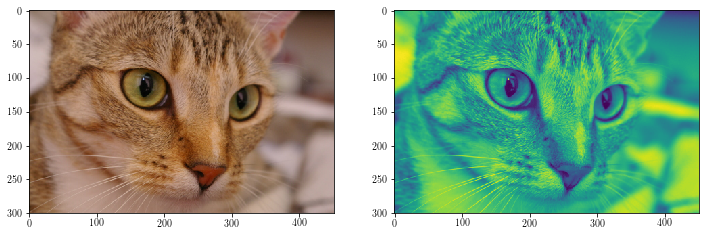

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
axes[0].imshow(img)
axes[1].imshow(img_grey)

In [5]:
# activation function
def relu(x):
    return x * (x > 0)

def drelu(x):
    return 1. * (x > 0)

In [6]:
# convolution function
def conv2d(image, filtr, mode = 'valid'):
    # filtr = np.rot90(filtr, 2) # rotate 180 degree
    image_row, image_col = image.shape
    filtr_row, filtr_col = filtr.shape
    if mode == 'full':
        zeros = np.zeros((filtr_row-1, image_col))
        extimg = np.vstack((zeros, image, zeros))
        zeros = np.zeros((extimg.shape[0], filtr_col-1))
        extimg = np.column_stack((zeros, extimg, zeros))
    elif mode == 'same':
        zeros = np.zeros((int(filtr_row/2), image_col))
        extimg = np.vstack((zeros, image, zeros))
        zeros = np.zeros((extimg.shape[0], int(filtr_col/2)))
        extimg = np.column_stack((zeros, extimg, zeros))
    else:
        extimg = image
        
    # print(extimg)
        
    row_start, row_end = 0, extimg.shape[0]-filtr.shape[0]+1
    col_start, col_end = 0, extimg.shape[1]-filtr.shape[1]+1
    result = np.zeros((row_end, col_end))
    for r in range(row_start, row_end):
        for c in range(col_start, col_end):
            cur_region = extimg[r:r+filtr_row, c:c+filtr_col]
            result[r, c] = np.sum(cur_region * filtr)
    return result

# image: (h, w[,c]); filters:(num, h, w[,c])
def conv(image, filters):
    # 1. check aurguments
    if len(image.shape) != len(filters.shape) - 1:
        print("number of dimension that image and filters not match!")
        return None
    if len(image.shape) == 3 and len(filters) == 4:
        if images.shape[-1] != filters.shape[-1]:
            print("the channel don't match!")
            return None
    if filters.shape[1] != filters.shape[2]:
        print("the filter must square matrix, row == column!")
        return None
    if filters.shape[1] % 2 == 0:
        print("the filter row or column must have odd size!")
        return None
    
    # 2. calculate the feature maps using conv mode: "valid"
    feature_maps = np.zeros((filters.shape[0],
                            image.shape[0] - filters.shape[1] + 1,
                            image.shape[1] - filters.shape[2] + 1))
    for fltr in range(filters.shape[0]):
        curr_filter = filters[fltr, :, :]
        conv_map = feature_maps[fltr, :, :]
        if len(curr_filter.shape) == 3: # have channel
            for ch in range(curr_filter.shape[-1]):
                conv_map += conv2d(image, curr_filter)
        else:
            conv_map = conv2d(image, curr_filter)
        feature_maps[fltr, :, :] = conv_map
    return feature_maps

In [7]:
def relu_mul(feature_maps):
    # Preparing the output of the ReLU activation function.
    relu_out = np.zeros(feature_maps.shape)
    for num in range(feature_maps.shape[0]):
        relu_out[num, :, :] = relu(feature_maps[num, :, :])
    # for num in range(feature_maps.shape[0]):
    #     for r in np.arange(0, feature_maps.shape[1]):
    #         for c in np.arange(0, feature_maps.shape[2]):
    #             relu_out[num, r, c] = np.max([feature_maps[num, r, c], 0])
    return relu_out

In [8]:
def pooling(feature_maps, size=2, stride=2):
    # Preparing the output of the pooling operation.
    pool_out = np.zeros((feature_maps.shape[0],
                         np.uint16((feature_maps.shape[1]-size+1)/stride+1),
                         np.uint16((feature_maps.shape[2]-size+1)/stride+1)))
    for num in range(feature_maps.shape[0]):
        r2 = 0
        for r in np.arange(0, feature_maps.shape[1]-size+1, stride):
            c2 = 0
            for c in np.arange(0, feature_maps.shape[2]-size+1, stride):
                pool_out[num, r2, c2] = np.max([feature_maps[num, r:r+size,  c:c+size]])
                c2 = c2 + 1
            r2 = r2 + 1
    return pool_out

In [9]:
filters = np.zeros((2, 3, 3))
# vertical edges
filters[0, :, :] = np.array([[[-1, 0, 1], 
                                   [-1, 0, 1], 
                                   [-1, 0, 1]]])
# horizontal edges
filters[1, :, :] = np.array([[[1, 1, 1], 
                                   [0, 0, 0], 
                                   [-1, -1, -1]]])

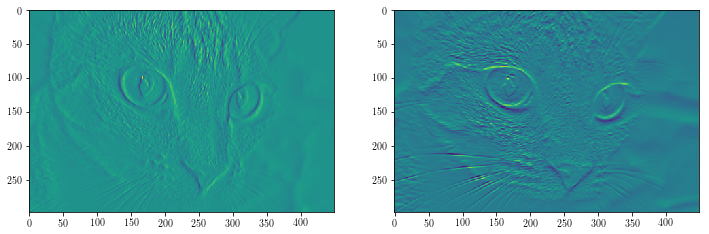

In [10]:
# test conv
feature_maps = conv(img_grey, filters)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
axes[0].imshow(feature_maps[0, :, :])
axes[1].imshow(feature_maps[1, :, :])

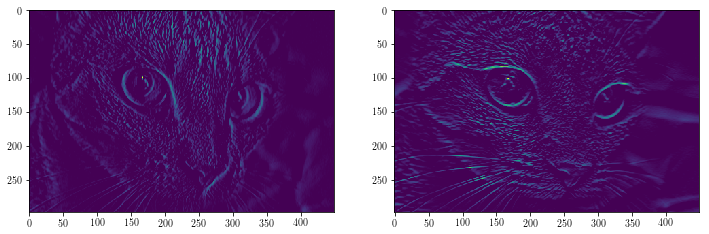

In [11]:
feature_maps_relu = relu_mul(feature_maps)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
axes[0].imshow(feature_maps_relu[0, :, :])
axes[1].imshow(feature_maps_relu[1, :, :])

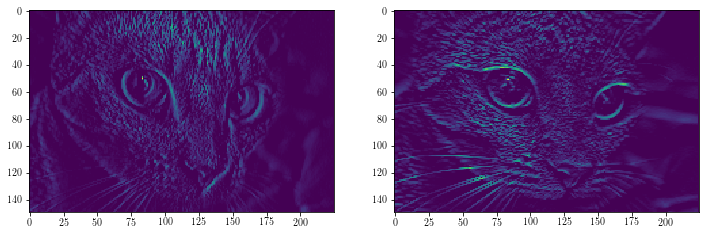

In [12]:
feature_maps_relu_pooling = pooling(feature_maps_relu)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
axes[0].imshow(feature_maps_relu_pooling[0, :, :])
axes[1].imshow(feature_maps_relu_pooling[1, :, :])